# Beam scan plotting and fitting script (Data measured from WinCamD)

### This script makes some assumptions about a few things:
 - Assumes some well established reference point from which you are measuring
 - Assumes the distance incrementation along z is in inches
 - Assumes you want to know about waist size and waist position

In [1]:
import pandas as pd
import scipy.optimize as sciopt
import numpy as np
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt

import data

In [3]:
fname = 'BS_10_24_2019'
data = pd.read_excel('../../measurements/'+fname+'.xlsx')
data_np = np.array(data)

In [4]:
data_np

array([['z (inches)', 'x diameter (\\mu m)', 'y diamter (\\mu m)'],
       [2, 919.8, 1433.5],
       [3, 881.5, 1302.5],
       [4, 810.8, 1125.9],
       [5, 776.6, 1074.5],
       [6, 745.9, 1028.9],
       [7, 660.7, 935.7],
       [8, 644.9, 838],
       [9, 618.4, 717.4],
       [10, 541.9, 630.5],
       [11, 545.2, 549.9],
       [12, 468.9, 432.6],
       [13, 454.2, 334],
       [14, 434.3, 282.2],
       [15, 434.2, 372.2],
       [16, 456.5, 492.6],
       [17, 532.4, 597.6],
       [18, 594.1, 692.5],
       [19, 673.9, 789],
       [20, 715.8, 885.1],
       [21, 761.3, 980.8]], dtype=object)

organize data

In [5]:
z = data_np[1:,0]
z_met = z*.0254
rad_x = data_np[1:,1]*.5e-6
rad_y = data_np[1:,2]*.5e-6

In [6]:
## Function that outputs the variance of the beam size function to the measured data
def int_w_z(params,wavelen, w_data, z_data):
    w0 = params[0]
    z0 = params[1]
    zr = (np.pi*(w0**2))/wavelen
    w = w0*((1 + ((z_data-z0)/zr)**2)**(.5))
    delta_w = (np.sum((w_data-w)**2))**(.5)
    return delta_w

In [7]:
wavelen = 1064e-9
params = [250e-6, .13] #initial guess

In [8]:
res_x = sciopt.minimize(int_w_z, params, args=(wavelen, rad_x, z_met),method = 'Nelder-Mead', tol=1e-6, options={'maxiter':1000,'disp':True})

Optimization terminated successfully.
         Current function value: 0.000072
         Iterations: 49
         Function evaluations: 95


In [9]:
res_x

 final_simplex: (array([[2.32757703e-04, 3.38113093e-01],
       [2.32756755e-04, 3.38112336e-01],
       [2.32756717e-04, 3.38112944e-01]]), array([7.1586095e-05, 7.1586095e-05, 7.1586095e-05]))
           fun: 7.158609495405284e-05
       message: 'Optimization terminated successfully.'
          nfev: 95
           nit: 49
        status: 0
       success: True
             x: array([2.32757703e-04, 3.38113093e-01])

In [10]:
res_y = sciopt.minimize(int_w_z, params, args=(wavelen, rad_y, z_met),method = 'Nelder-Mead', tol=1e-6, options={'maxiter':1000})

In [11]:
res_y

 final_simplex: (array([[1.36934639e-04, 3.44047223e-01],
       [1.36934446e-04, 3.44046223e-01],
       [1.36933312e-04, 3.44046622e-01]]), array([0.00015957, 0.00015957, 0.00015957]))
           fun: 0.0001595747976772316
       message: 'Optimization terminated successfully.'
          nfev: 120
           nit: 63
        status: 0
       success: True
             x: array([1.36934639e-04, 3.44047223e-01])

In [12]:
def w_beam(z,wavelen, W_o,z_o):
    zr = (np.pi*(W_o**2))/wavelen
    return W_o*((1+((z-z_o)/zr)**2)**.5)

In [13]:
new_z_horiz = np.arange(res_x.x[1]-.75, res_x.x[1]+.75,.001)
new_z_vert = np.arange(res_y.x[1]-.75, res_y.x[1]+.75,.001)

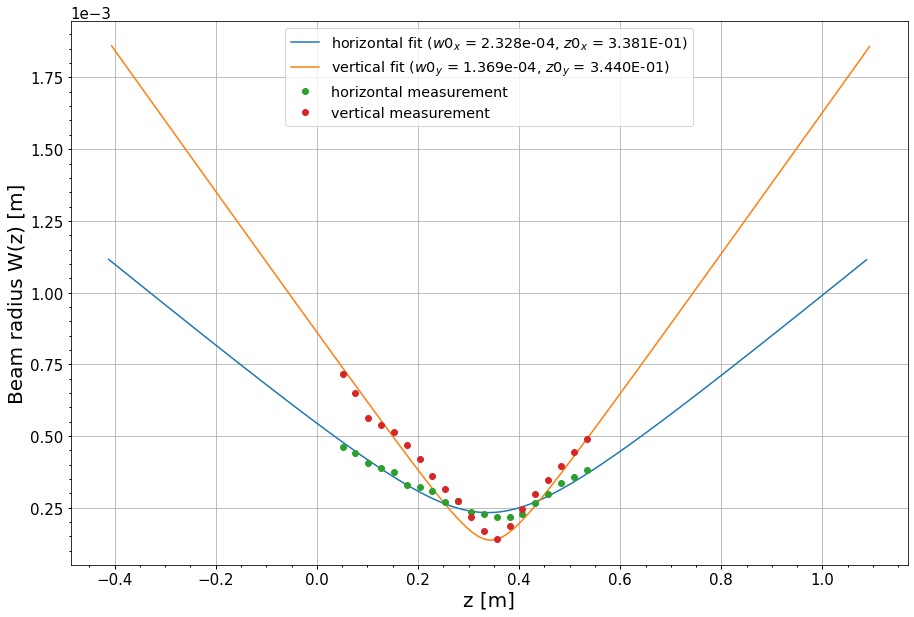

In [14]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.plot(new_z_horiz, w_beam(new_z_horiz,wavelen,res_x.x[0],res_x.x[1]), label='horizontal fit ($w0_x$ = {}, $z0_x$ = {})'.format("{:.3e}".format(res_x.x[0]),"{:.3E}".format(res_x.x[1])))
plt.plot(new_z_vert, w_beam(new_z_vert,wavelen,res_y.x[0],res_y.x[1]), label= 'vertical fit ($w0_y$ = {}, $z0_y$ = {})'.format("{:.3e}".format(res_y.x[0]),"{:.3E}".format(res_y.x[1])))
plt.plot(z_met,rad_x,'o', label='horizontal measurement')
plt.plot(z_met,rad_y,'o', label='vertical measurement')
plt.legend(fontsize='x-large')
plt.ylabel('Beam size W(z) [m]',fontsize=20)
plt.xlabel('z [m]',fontsize=20)
#plt.grid('True', which='both')
plt.grid('True')
ax.tick_params(which='both', width=1)
#ax.tick_params(which='minor', length=2)
ax.tick_params(labelsize=15)
ax.ticklabel_format(axis='y',style='sci', scilimits=(0,1e-6))
ax.yaxis.offsetText.set_fontsize(15)
plt.savefig(fname+'_results.png',dpi=300,bbox_inches='tight')
